<a href="https://colab.research.google.com/github/oscar-sinaga/predict_price_hotel/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Env and install Libraries

In [1]:
# 1. Clone repository
!git clone https://github.com/oscar-sinaga/predict_price_hotel.git
!pip install pmdarima
%cd /content/predict_price_hotel
from pmdarima import auto_arima
import pandas as pd
from predict_price_clean import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

Cloning into 'predict_price_hotel'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 42 (delta 19), reused 13 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 10.76 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (19/19), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 7.5 MB/s eta 0:00:00
/content/predict_price_hotel


# Read and

In [2]:

# ==============================================================================
# INISIALISASI DATA
# ==============================================================================
#@markdown ---
#@markdown ### Read the Data

FILE_DATASET = 'histories_room_ota2.xlsx' #@param {type:"string"}
print("⏳ Membaca dataset... (Mohon tunggu sebentar)")

# Membuka file sesuai format (kalau .csv ganti jadi read_csv)
if FILE_DATASET.endswith('.csv'):
    df = pd.read_csv(FILE_DATASET)
else:
    df = pd.read_excel(FILE_DATASET)

print("✅ Dataset berhasil dibaca")
#

⏳ Membaca dataset... (Mohon tunggu sebentar)


# Modelling

In [3]:
# @title
# # @title
# # ==============================================================================
# # CLASS 1: MODEL ARIMA
# # ==============================================================================
# class PriceForecast:
#     def initialize_data(self, date_all, price_all, hotel_name_all, room_name_all, ota_all):
#         price_numeric = pd.to_numeric(price_all, errors='coerce')
#         date_dt = pd.to_datetime(date_all, errors='coerce')
#         data = pd.DataFrame({
#             'date': date_dt,
#             'price': price_numeric,
#             'hotel_name': hotel_name_all,
#             'room_name': room_name_all,
#             'ota': ota_all
#         })
#         self.data = data.dropna(subset=['date', 'price'])
#         return self.data

#     def read_data(self, hotel_name, room_name, ota):
#         df = self.data[(self.data['hotel_name'] == hotel_name) &
#                        (self.data['room_name'] == room_name) &
#                        (self.data['ota'] == ota)].copy()
#         df = df.sort_values(by='date').reset_index(drop=True)
#         self.df = df
#         return df

#     def imputation(self):
#         df = self.df.copy()
#         df = df.drop_duplicates(subset=['date'])
#         df = df.set_index('date')
#         df = df.asfreq('D')
#         df['price'] = df['price'].ffill().bfill()
#         df = df.reset_index()
#         df['hotel_name'] = self.df['hotel_name'].iloc[0]
#         df['room_name'] = self.df['room_name'].iloc[0]
#         df['ota'] = self.df['ota'].iloc[0]
#         self.df_interpolated = df
#         return df

#     def get_forecast_date(self, train, days_pred):
#         tanggal_pilihan = train['date'].iloc[-1]
#         semua_tanggal = []
#         for i in range(days_pred):
#             tanggal_sekarang = tanggal_pilihan + timedelta(days=i + 1)
#             semua_tanggal.append(tanggal_sekarang.strftime('%Y-%m-%d'))
#         return semua_tanggal

#     def model_predict(self, days_pred=14):
#         df_interpolated = self.imputation()
#         train = df_interpolated[-90:].copy()
#         train['price_log'] = np.log1p(train['price'].astype(float))

#         best_sarima = auto_arima(train['price_log'], seasonal=True, m=7, stepwise=True, trace=False)
#         p, d, q = best_sarima.order
#         P, D, Q, s = best_sarima.seasonal_order

#         model = SARIMAX(train['price_log'], order=(p, d, q), seasonal_order=(P, D, Q, s))
#         model_fit = model.fit(disp=False)

#         forecast_log = model_fit.forecast(steps=days_pred)
#         forecast_cis_log = model_fit.get_forecast(steps=days_pred).conf_int(alpha=0.01)

#         forecast = np.expm1(forecast_log)
#         lower_price = np.expm1(forecast_cis_log.iloc[:, 0])
#         upper_price = np.expm1(forecast_cis_log.iloc[:, 1])

#         forecast_date = self.get_forecast_date(train, days_pred)
#         df_forecast = pd.DataFrame({
#             'date': forecast_date,
#             'price': forecast.values,
#             'lower price': lower_price.values,
#             'upper price': upper_price.values
#         })
#         df_forecast['date'] = pd.to_datetime(df_forecast['date'])

#         self.df_forecast = df_forecast
#         self.train = train
#         return df_forecast

#     def plot_prediction(self):
#         forecast = self.df_forecast
#         train = self.train
#         alpha = 0.1

#         plt.figure(figsize=(14, 6))
#         past_plot = train.tail(90)

#         plt.plot(past_plot['date'], past_plot['price'], label='Historical Data (Last 90 Days)', color='blue')
#         plt.plot(forecast['date'], forecast['price'], label='SARIMA Forecast', color='red', linestyle='--', marker='o')
#         plt.fill_between(forecast['date'], forecast['lower price'], forecast['upper price'], alpha=0.15,
#                          label=f'{int((1 - alpha) * 100)}% Confidence Interval', color='red')

#         # PERBAIKAN: Fokuskan sumbu Y agar tidak terdistorsi oleh CI yang terlalu besar
#         y_min = min(past_plot['price'].min(), forecast['price'].min())
#         y_max = max(past_plot['price'].max(), forecast['price'].max())
#         margin = (y_max - y_min) * 0.15 # Padding atas & bawah 15%
#         plt.ylim(max(0, y_min - margin), y_max + margin)

#         plt.legend()
#         plt.xlabel('Date')
#         plt.ylabel('Price')
#         plt.title(f'SARIMA Forecasting - {self.df["hotel_name"].iloc[0]}')
#         plt.xticks(rotation=45)
#         plt.grid(True, alpha=0.3)
#         plt.tight_layout()
#         plt.show()

#     def evaluate_model(self, days_pred=14):
#         df_interpolated = self.imputation()

#         train = df_interpolated.iloc[:-days_pred].copy()
#         test = df_interpolated.iloc[-days_pred:].copy()

#         train_subset = train[-90:].copy()
#         train_subset['price_log'] = np.log1p(train_subset['price'].astype(float))

#         best_sarima = auto_arima(train_subset['price_log'], seasonal=True, m=7, stepwise=True, trace=False)
#         p, d, q = best_sarima.order
#         P, D, Q, s = best_sarima.seasonal_order

#         model = SARIMAX(train_subset['price_log'], order=(p, d, q), seasonal_order=(P, D, Q, s))
#         model_fit = model.fit(disp=False)

#         forecast_log = model_fit.forecast(steps=len(test))
#         forecast_cis_log = model_fit.get_forecast(steps=len(test)).conf_int(alpha=0.01)

#         forecast = np.expm1(forecast_log)
#         lower_price = np.expm1(forecast_cis_log.iloc[:, 0])
#         upper_price = np.expm1(forecast_cis_log.iloc[:, 1])

#         self.eval_train = train_subset
#         self.eval_test = test
#         self.eval_forecast = forecast.values
#         self.eval_lower = lower_price.values
#         self.eval_upper = upper_price.values

#         mape_list = []
#         for i in range(len(test)):
#             y_true_val = float(test['price'].iloc[i])
#             y_pred_val = float(forecast.iloc[i])
#             mape = np.abs((y_true_val - y_pred_val) / y_true_val) if y_true_val != 0 else 0
#             mape_list.append(mape)

#         self.mape_list = mape_list

#         df_eval = pd.DataFrame({
#             'window_hari': range(1, len(test) + 1),
#             'date': test['date'].dt.strftime('%Y-%m-%d').values,
#             'actual_price': test['price'].values,
#             'forecast_price': forecast.values,
#             'mape_percentage': [f"{m:.2%}" for m in mape_list]
#         })
#         return df_eval

#     def plot_evaluation(self):
#         train = self.eval_train
#         test = self.eval_test
#         forecast = self.eval_forecast
#         lower_price = self.eval_lower
#         upper_price = self.eval_upper
#         mape_list = self.mape_list

#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

#         train_plot = train.tail(90)
#         ax1.plot(train_plot['date'], train_plot['price'], label='Train Data (Last 90 days)', color='blue', alpha=0.6)
#         ax1.plot(test['date'], test['price'], label='Actual Test Data', color='green', marker='o')
#         ax1.plot(test['date'], forecast, label='Forecast', color='red', linestyle='--', marker='x')
#         ax1.fill_between(test['date'], lower_price, upper_price, color='red', alpha=0.15, label='99% Confidence Interval')

#         # PERBAIKAN: Kunci skala sumbu Y agar grafik forecast jelas
#         y_min = min(train_plot['price'].min(), test['price'].min(), forecast.min())
#         y_max = max(train_plot['price'].max(), test['price'].max(), forecast.max())
#         margin = (y_max - y_min) * 0.15
#         ax1.set_ylim(max(0, y_min - margin), y_max + margin)

#         ax1.set_xlabel('Date')
#         ax1.set_ylabel('Price')
#         ax1.set_title(f'Train vs Test vs Forecast (ARIMA)\n{self.df["hotel_name"].iloc[0]}')
#         ax1.legend()
#         ax1.tick_params(axis='x', rotation=45)

#         windows = range(1, len(mape_list) + 1)
#         ax2.plot(windows, mape_list, marker='o', color='purple')
#         ax2.set_xlabel('Window Prediction (Hari ke-)')
#         ax2.set_ylabel('MAPE')
#         ax2.set_title('MAPE tiap Window Prediction (ARIMA)')
#         ax2.set_xticks(windows)

#         for i, val in enumerate(mape_list):
#             ax2.text(windows[i], val, f'{val:.1%}', ha='center', va='bottom', fontsize=9)

#         ax2.grid(True, linestyle='--', alpha=0.6)

#         plt.tight_layout()
#         plt.show()


# # ==============================================================================
# # CLASS 2: MODEL RANDOM FOREST
# # ==============================================================================
# class PriceForecastRevamped:
#     def initialize_data(self, date_all, price_all, hotel_name_all, room_name_all, ota_all):
#         date_dt = pd.to_datetime(date_all, errors='coerce')
#         price_numeric = pd.to_numeric(price_all, errors='coerce')
#         self.data = pd.DataFrame({
#             'date': date_dt,
#             'price': price_numeric,
#             'hotel_name': hotel_name_all,
#             'room_name': room_name_all,
#             'ota': ota_all
#         })
#         self.data = self.data.dropna(subset=['date', 'price'])
#         return self.data

#     def read_data(self, hotel_name, room_name, ota):
#         df = self.data[
#             (self.data['hotel_name'] == hotel_name) &
#             (self.data['room_name'] == room_name) &
#             (self.data['ota'] == ota)
#         ].copy()
#         df = df.sort_values('date').reset_index(drop=True)
#         self.df = df
#         return df

#     def imputation(self):
#         df = self.df.set_index('date')
#         df = df.asfreq('D')
#         df['price'] = df['price'].ffill().bfill()
#         df = df.reset_index()
#         df['hotel_name'] = self.df['hotel_name'].iloc[0]
#         df['room_name'] = self.df['room_name'].iloc[0]
#         df['ota'] = self.df['ota'].iloc[0]
#         self.df_interpolated = df
#         return df

#     def extract_features(self, df):
#         df = df.copy()
#         df['day_of_week'] = df['date'].dt.dayofweek
#         df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
#         df['day_of_month'] = df['date'].dt.day
#         df['month'] = df['date'].dt.month
#         df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
#         return df

#     def train_model(self):
#         df_clean = self.imputation()
#         df_features = self.extract_features(df_clean)

#         features = ['day_of_week', 'is_weekend', 'day_of_month', 'month', 'days_since_start']
#         X = df_features[features]
#         y = df_features['price']

#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#         model = RandomForestRegressor(n_estimators=100, random_state=42)
#         model.fit(X_train, y_train)

#         self.model = model
#         self.df_features = df_features
#         self.features = features
#         self.start_date = df_clean['date'].min()
#         return model

#     def model_predict(self, days_pred=14):
#         if not hasattr(self, 'model'):
#             self.train_model()

#         last_date = self.df_features['date'].max()
#         future_dates = [last_date + timedelta(days=i) for i in range(1, days_pred + 1)]
#         df_future = pd.DataFrame({'date': future_dates})

#         df_future['day_of_week'] = df_future['date'].dt.dayofweek
#         df_future['is_weekend'] = df_future['day_of_week'].isin([5, 6]).astype(int)
#         df_future['day_of_month'] = df_future['date'].dt.day
#         df_future['month'] = df_future['date'].dt.month
#         df_future['days_since_start'] = (df_future['date'] - self.start_date).dt.days

#         X_future = df_future[self.features]

#         all_tree_predictions = np.stack([tree.predict(X_future.values) for tree in self.model.estimators_])
#         mean_predictions = all_tree_predictions.mean(axis=0)
#         std_dev = all_tree_predictions.std(axis=0)
#         margin = 1.96 * std_dev

#         df_future['predicted_price'] = mean_predictions
#         df_future['lower_price'] = mean_predictions - margin
#         df_future['upper_price'] = mean_predictions + margin

#         self.df_forecast = df_future
#         return df_future[['date', 'predicted_price', 'lower_price', 'upper_price']]

#     def plot_prediction(self):
#         past_data = self.df_features
#         forecast = self.df_forecast

#         plt.figure(figsize=(14, 6))
#         past_plot = past_data.tail(90)

#         plt.plot(past_plot['date'], past_plot['price'], label='Historical Data (Last 90 Days)', color='blue')
#         plt.plot(forecast['date'], forecast['predicted_price'], label='RF Forecast', color='red', linestyle='--', marker='o')
#         plt.fill_between(forecast['date'], forecast['lower_price'], forecast['upper_price'], alpha=0.15,
#                          label='95% Confidence Interval (Est. via Trees StdDev)', color='red')

#         # PERBAIKAN: Fokuskan sumbu Y
#         y_min = min(past_plot['price'].min(), forecast['predicted_price'].min())
#         y_max = max(past_plot['price'].max(), forecast['predicted_price'].max())
#         margin = (y_max - y_min) * 0.15
#         plt.ylim(max(0, y_min - margin), y_max + margin)

#         plt.legend()
#         plt.xlabel('Date')
#         plt.ylabel('Price')
#         plt.title(f'ML (Random Forest) Price Forecasting - {self.df["hotel_name"].iloc[0]}')
#         plt.grid(True, alpha=0.3)
#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.show()

#     def evaluate_model(self, days_pred=14):
#         df_clean = self.imputation()
#         df_features = self.extract_features(df_clean)

#         train = df_features.iloc[:-days_pred].copy()
#         test = df_features.iloc[-days_pred:].copy()

#         features = ['day_of_week', 'is_weekend', 'day_of_month', 'month', 'days_since_start']
#         X_train, y_train = train[features], train['price']
#         X_test, y_test = test[features], test['price']

#         model = RandomForestRegressor(n_estimators=100, random_state=42)
#         model.fit(X_train, y_train)

#         all_tree_predictions = np.stack([tree.predict(X_test.values) for tree in model.estimators_])
#         forecast = all_tree_predictions.mean(axis=0)
#         std_dev = all_tree_predictions.std(axis=0)
#         margin = 1.96 * std_dev

#         lower_price = forecast - margin
#         upper_price = forecast + margin

#         self.eval_train = train
#         self.eval_test = test
#         self.eval_forecast = forecast
#         self.eval_lower = lower_price
#         self.eval_upper = upper_price

#         mape_list = []
#         for i in range(len(test)):
#             y_true_val = test['price'].iloc[i]
#             y_pred_val = forecast[i]
#             mape = np.abs((y_true_val - y_pred_val) / y_true_val) if y_true_val != 0 else 0
#             mape_list.append(mape)

#         self.mape_list = mape_list

#         df_eval = pd.DataFrame({
#             'window_hari': range(1, len(test) + 1),
#             'date': test['date'].dt.strftime('%Y-%m-%d').values,
#             'actual_price': test['price'].values,
#             'forecast_price': forecast,
#             'mape_percentage': [f"{m:.2%}" for m in mape_list]
#         })
#         return df_eval

#     def plot_evaluation(self):
#         train = self.eval_train
#         test = self.eval_test
#         forecast = self.eval_forecast
#         lower_price = self.eval_lower
#         upper_price = self.eval_upper
#         mape_list = self.mape_list

#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

#         train_plot = train.tail(90)
#         ax1.plot(train_plot['date'], train_plot['price'], label='Train Data (Last 90 days)', color='blue', alpha=0.6)
#         ax1.plot(test['date'], test['price'], label='Actual Test Data', color='green', marker='o')
#         ax1.plot(test['date'], forecast, label='Forecast', color='red', linestyle='--', marker='x')
#         ax1.fill_between(test['date'], lower_price, upper_price, color='red', alpha=0.15, label='95% Confidence Interval')

#         # PERBAIKAN: Kunci skala sumbu Y
#         y_min = min(train_plot['price'].min(), test['price'].min(), forecast.min())
#         y_max = max(train_plot['price'].max(), test['price'].max(), forecast.max())
#         margin = (y_max - y_min) * 0.15
#         ax1.set_ylim(max(0, y_min - margin), y_max + margin)

#         ax1.set_xlabel('Date')
#         ax1.set_ylabel('Price')
#         ax1.set_title(f'Train vs Test vs Forecast (Random Forest)\n{self.df["hotel_name"].iloc[0]}')
#         ax1.legend()
#         ax1.tick_params(axis='x', rotation=45)

#         windows = range(1, len(mape_list) + 1)
#         ax2.plot(windows, mape_list, marker='o', color='purple')
#         ax2.set_xlabel('Window Prediction (Hari ke-)')
#         ax2.set_ylabel('MAPE')
#         ax2.set_title('MAPE tiap Window Prediction (Random Forest)')
#         ax2.set_xticks(windows)

#         for i, val in enumerate(mape_list):
#             ax2.text(windows[i], val, f'{val:.1%}', ha='center', va='bottom', fontsize=9)

#         ax2.grid(True, linestyle='--', alpha=0.6)

#         plt.tight_layout()
#         plt.show()

✅ Memproses data untuk: Melia Purosani Yogyakarta | Deluxe Room | traveloka

>>> MEMULAI PROSES MODEL 1: ARIMA (SARIMA) <<<
Melakukan evaluasi Backtesting untuk 14 hari...

Hasil Evaluasi (MAPE) - ARIMA:
 window_hari       date  actual_price  forecast_price mape_percentage
           1 2023-09-19     1665000.0    1.664469e+06           0.03%
           2 2023-09-20     1618750.0    1.716312e+06           6.03%
           3 2023-09-21     1618750.0    1.725206e+06           6.58%
           4 2023-09-22     1850000.0    1.696503e+06           8.30%
           5 2023-09-23     1850000.0    1.773685e+06           4.13%
           6 2023-09-24     1480000.0    1.625780e+06           9.85%
           7 2023-09-25     1480000.0    1.683068e+06          13.72%
           8 2023-09-26     1618750.0    1.675617e+06           3.51%
           9 2023-09-27     1641875.0    1.719216e+06           4.71%
          10 2023-09-28     1641875.0    1.714729e+06           4.44%
          11 2023-09-29   

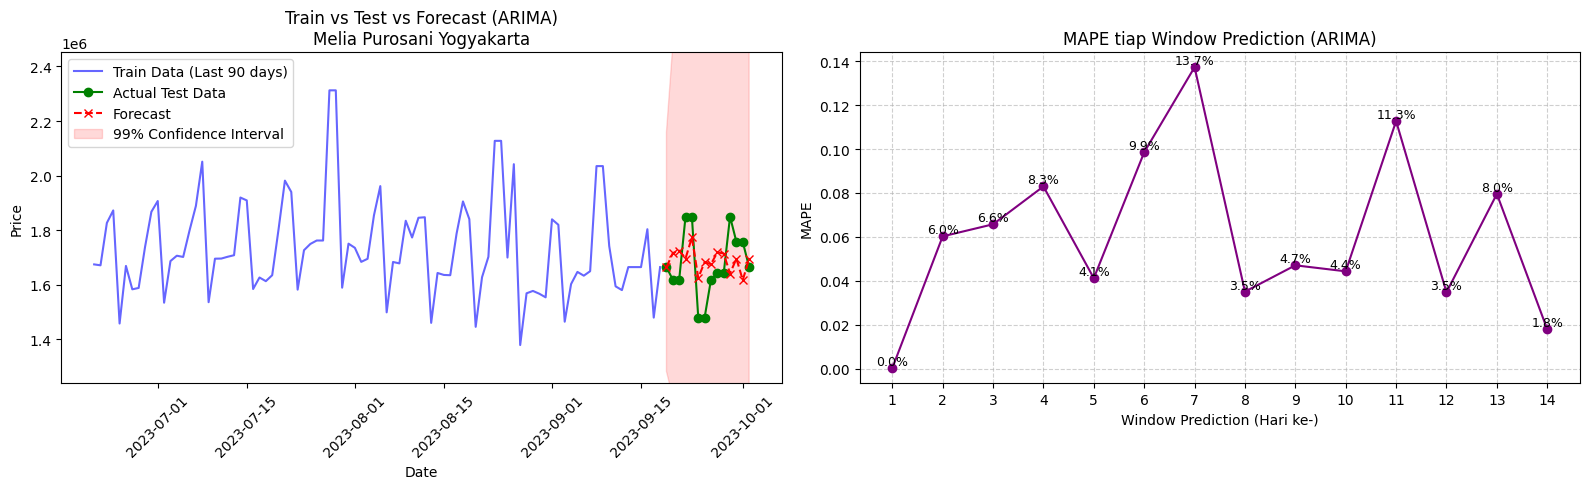


Melakukan prediksi harga untuk 7 hari ke depan...

Hasil Prediksi Masa Depan - ARIMA:
      date         price  lower price  upper price
2023-10-03 164129.851584   621.877605 4.324916e+07
2023-10-04  22860.998003     7.979694 5.820587e+07
2023-10-05  20360.186028     6.997430 5.183889e+07
2023-10-06  20597.611210     7.090685 5.244337e+07
2023-10-07  19204.670290     6.543568 4.889699e+07
2023-10-08  23119.670024     8.081295 5.886444e+07
2023-10-09  31722.490170    11.460295 8.076693e+07


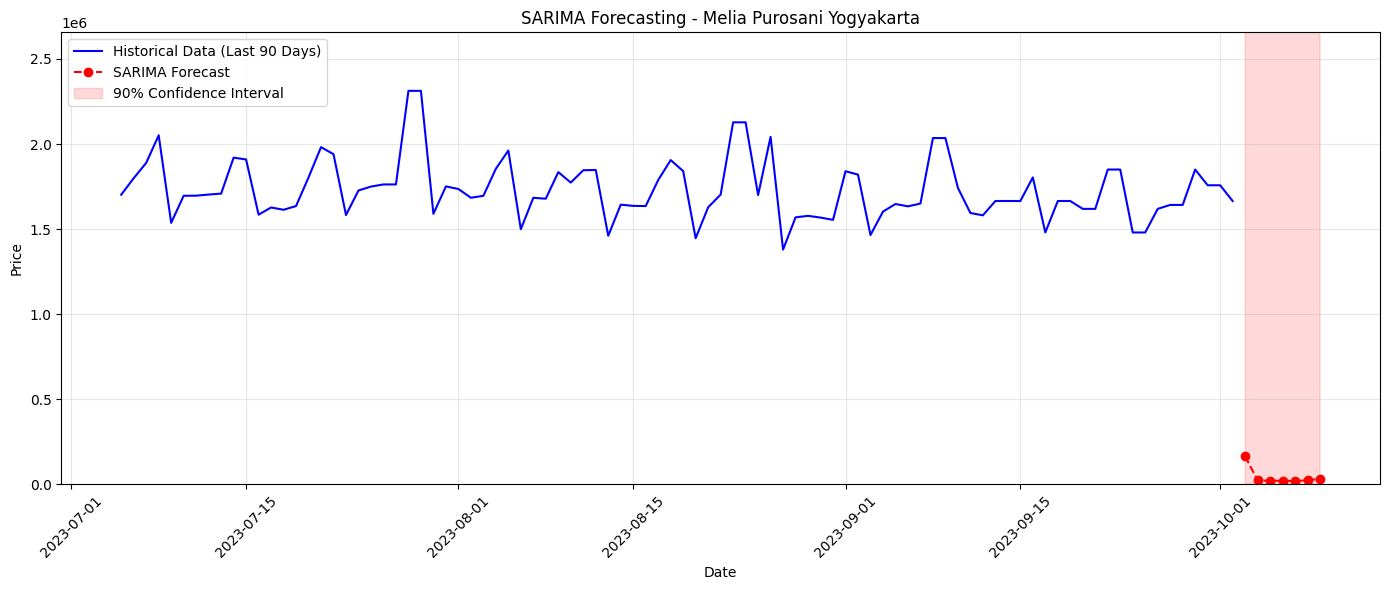

>>> MEMULAI PROSES MODEL 2: RANDOM FOREST <<<
Melakukan evaluasi Backtesting untuk 14 hari...

Hasil Evaluasi (MAPE) - Random Forest:
 window_hari       date  actual_price  forecast_price mape_percentage
           1 2023-09-19     1665000.0      1652786.39           0.73%
           2 2023-09-20     1618750.0      1685385.34           4.12%
           3 2023-09-21     1618750.0      1755158.34           8.43%
           4 2023-09-22     1850000.0      1811283.78           2.09%
           5 2023-09-23     1850000.0      1835410.43           0.79%
           6 2023-09-24     1480000.0      1528819.20           3.30%
           7 2023-09-25     1480000.0      1690699.36          14.24%
           8 2023-09-26     1618750.0      1671462.57           3.26%
           9 2023-09-27     1641875.0      1661330.38           1.18%
          10 2023-09-28     1641875.0      1724588.14           5.04%
          11 2023-09-29     1850000.0      2030982.51           9.78%
          12 2023-09-30   

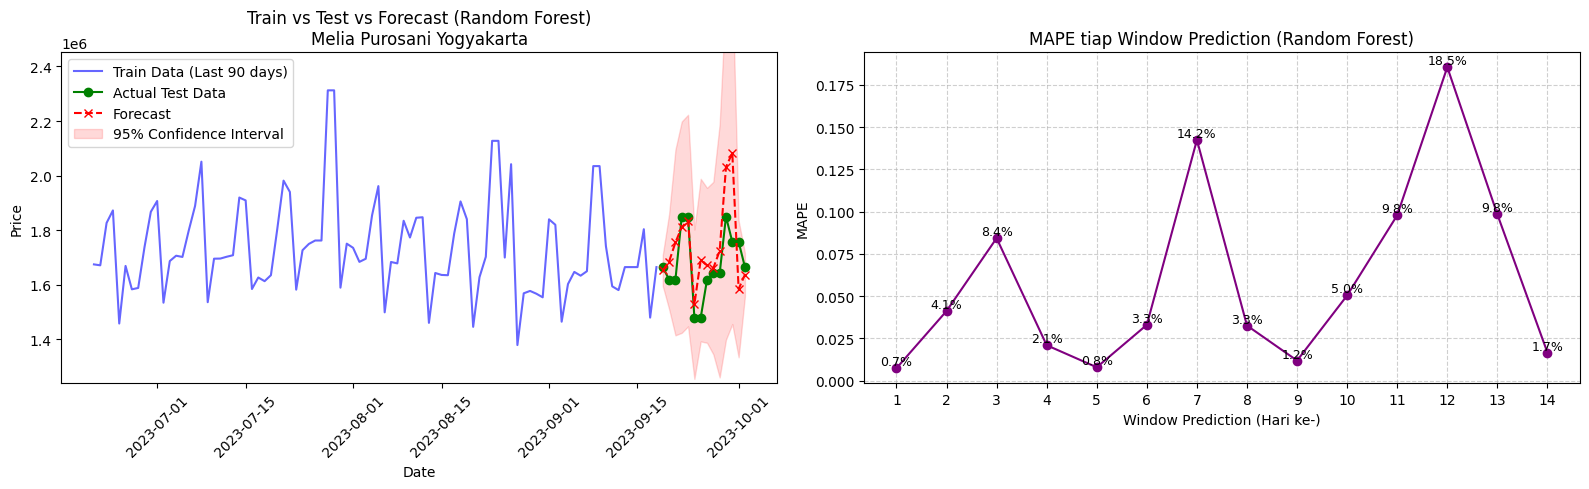


Melakukan prediksi harga untuk 7 hari ke depan...

Hasil Prediksi Masa Depan - Random Forest:
      date  predicted_price  lower_price  upper_price
2023-10-03       1663973.61 1.604186e+06 1.723762e+06
2023-10-04       1664099.10 1.587346e+06 1.740852e+06
2023-10-05       1679522.57 1.560488e+06 1.798557e+06
2023-10-06       1870850.01 1.581137e+06 2.160563e+06
2023-10-07       1878625.27 1.599990e+06 2.157260e+06
2023-10-08       1645184.33 1.383271e+06 1.907098e+06
2023-10-09       1646495.07 1.591359e+06 1.701631e+06


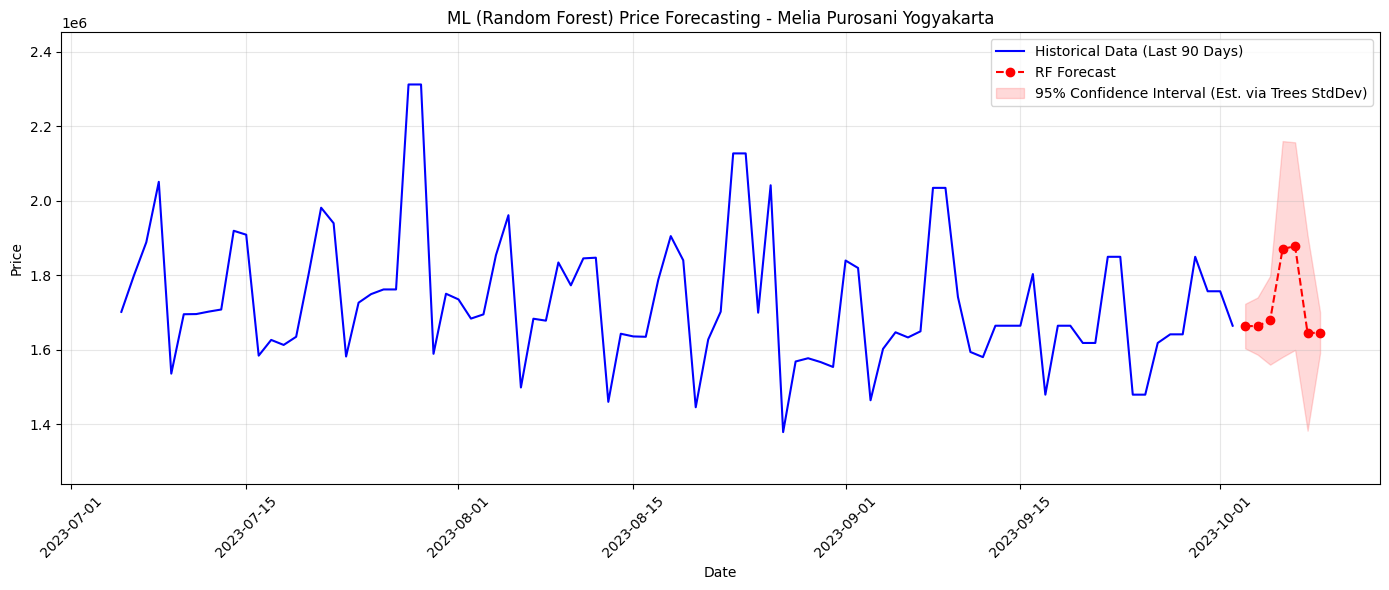


🎉 >>> SELURUH PROSES SELESAI <<< 🎉


In [4]:
#@title 🏨 Panel Kontrol Prediksi Harga Hotel
#@markdown ---
#@markdown ### 💡 Rekomendasi Data Kombinasi (Bisa di Copy-Paste):
#@markdown *Jika bingung mau mencoba data apa, silakan copy salah satu dari 10 kombinasi terbanyak di bawah ini:*
#@markdown
#@markdown | No | NAMA_HOTEL | NAMA_KAMAR | NAMA_OTA |
#@markdown |:---:|:---|:---|:---|
#@markdown | 1 | `Horison Nindya Semarang` | `Superior` | `agoda` |
#@markdown | 2 | `Horison Ultima Makassar` | `Kamar Superior Twin` | `tiket` |
#@markdown | 3 | `Horison Ultima Bhuvana Ciawi` | `Deluxe Twin` | `agoda` |
#@markdown | 4 | `Yogyakarta Marriott Hotel` | `Deluxe, Guest room, 2 Twin/Single Bed(s), City view` | `agoda` |
#@markdown | 5 | `@Hom Premiere Cilacap Hotel` | `Executive Suite` | `agoda` |
#@markdown | 6 | `HOM Semarang Simpang Lima By Horison` | `Superior Double` | `agoda` |
#@markdown | 7 | `Horison Ultima Makassar` | `Suite Junior Double` | `tiket` |
#@markdown | 8 | `Horison Ultima Ratu Serang` | `Deluxe Twin` | `agoda` |
#@markdown | 9 | `HORISON GKB Gresik` | `Deluxe Double` | `agoda` |
#@markdown | 10 | `Yogyakarta Marriott Hotel` | `Club Pool, M Club lounge access, Guest room` | `agoda` |
#@markdown ---
#@markdown ### ⚙️ 1. Pengaturan Dataset & Filter
#@markdown Masukkan nama file, nama hotel, tipe kamar, dan nama OTA (huruf besar/kecil harus persis).
NAMA_HOTEL = 'Melia Purosani Yogyakarta' #@param {type:"string"}
NAMA_KAMAR = 'Deluxe Room' #@param {type:"string"}
NAMA_OTA = 'traveloka' #@param {type:"string"}

#@markdown ---
#@markdown ### 📈 2. Pengaturan Rentang Waktu (Window)
#@markdown Tentukan berapa hari data historis yang ingin diuji coba dan berapa hari ke depan yang ingin diprediksi.

HARI_EVALUASI = 14 #@param {type:"integer"}
HARI_PREDIKSI = 7 #@param {type:"integer"}
#@markdown ---

import pandas as pd
import warnings
warnings.filterwarnings('ignore')



date = df['Date']
price = df['Price']
hotel_name = df['Hotel Name']
room_name = df['Room Name']
ota = df['OTA']

print(f"✅ Memproses data untuk: {NAMA_HOTEL} | {NAMA_KAMAR} | {NAMA_OTA}\n")
print("=" * 70)

# ==============================================================================
# EKSEKUSI MODEL 1: ARIMA (SARIMA)
# ==============================================================================
print(">>> MEMULAI PROSES MODEL 1: ARIMA (SARIMA) <<<")
model_arima = PriceForecast()

# Load & Filter Data
model_arima.initialize_data(date, price, hotel_name, room_name, ota)
model_arima.read_data(NAMA_HOTEL, NAMA_KAMAR, NAMA_OTA)

# Evaluasi Train & Test (Mencakup Imputasi & Evaluasi)
print(f"Melakukan evaluasi Backtesting untuk {HARI_EVALUASI} hari...")
eval_arima = model_arima.evaluate_model(days_pred=HARI_EVALUASI)
print("\nHasil Evaluasi (MAPE) - ARIMA:")
print(eval_arima[['window_hari', 'date', 'actual_price', 'forecast_price', 'mape_percentage']].to_string(index=False))

# Plot Evaluasi ARIMA
model_arima.plot_evaluation()

# Prediksi Masa Depan
print(f"\nMelakukan prediksi harga untuk {HARI_PREDIKSI} hari ke depan...")
pred_arima = model_arima.model_predict(days_pred=HARI_PREDIKSI)
print("\nHasil Prediksi Masa Depan - ARIMA:")
print(pred_arima.to_string(index=False))

# Plot Prediksi ARIMA
model_arima.plot_prediction()

print("=" * 70)

# ==============================================================================
# EKSEKUSI MODEL 2: RANDOM FOREST (Machine Learning)
# ==============================================================================
print(">>> MEMULAI PROSES MODEL 2: RANDOM FOREST <<<")
model_rf = PriceForecastRevamped()

# Load & Filter Data
model_rf.initialize_data(date, price, hotel_name, room_name, ota)
model_rf.read_data(NAMA_HOTEL, NAMA_KAMAR, NAMA_OTA)

# Evaluasi Train & Test (Mencakup Imputasi, Feature Engineering & Evaluasi)
print(f"Melakukan evaluasi Backtesting untuk {HARI_EVALUASI} hari...")
eval_rf = model_rf.evaluate_model(days_pred=HARI_EVALUASI)
print("\nHasil Evaluasi (MAPE) - Random Forest:")
print(eval_rf[['window_hari', 'date', 'actual_price', 'forecast_price', 'mape_percentage']].to_string(index=False))

# Plot Evaluasi RF
model_rf.plot_evaluation()

# Prediksi Masa Depan
print(f"\nMelakukan prediksi harga untuk {HARI_PREDIKSI} hari ke depan...")
pred_rf = model_rf.model_predict(days_pred=HARI_PREDIKSI)
print("\nHasil Prediksi Masa Depan - Random Forest:")
print(pred_rf.to_string(index=False))

# Plot Prediksi RF
model_rf.plot_prediction()

print("\n🎉 >>> SELURUH PROSES SELESAI <<< 🎉")